In [1]:
%load_ext autoreload
%autoreload 2

In [9]:
from data import RoadSatelliteModule
from system import SemanticSegmentationSystem

from models import *

import numpy as np
import matplotlib.pyplot as plt
import random

import torchvision
import torchvision.transforms.functional as F

import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint

import torch
from torchinfo import summary

import regex as re

In [10]:
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

# 1. Preparation

In [11]:
batch_size = 8
num_workers = 8

In [12]:
pl.seed_everything(7, workers=True)

Global seed set to 7


7

## 1.1 DataModule

In [13]:
road_data = RoadSatelliteModule(num_workers=num_workers, batch_size=batch_size)

In [14]:
%%time
X, y = next(iter(road_data.val_dataloader()))

CPU times: user 2.11 s, sys: 1.88 s, total: 3.98 s
Wall time: 6.2 s


In [15]:
imgs, masks = next(iter(road_data.test_dataloader()))

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


## 1.2 Inspect Data

In [16]:
def show_image(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

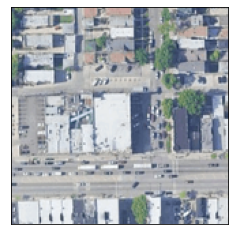

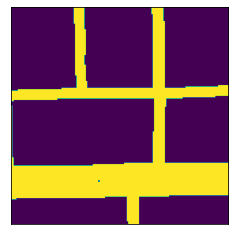

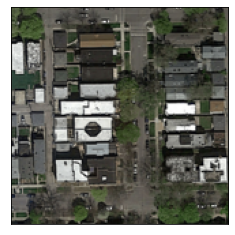

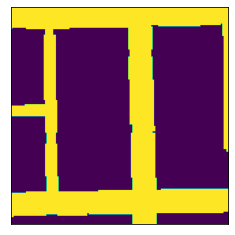

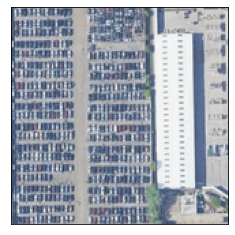

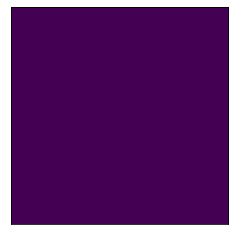

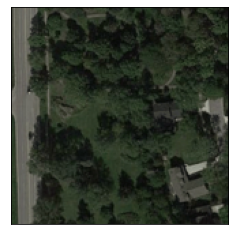

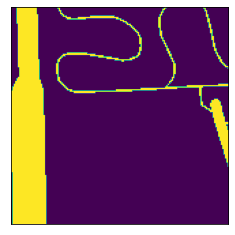

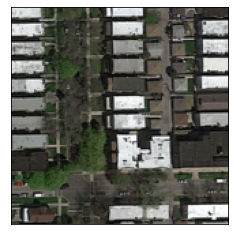

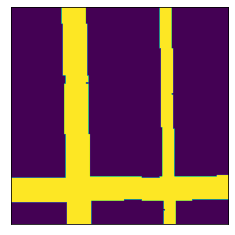

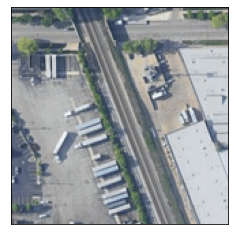

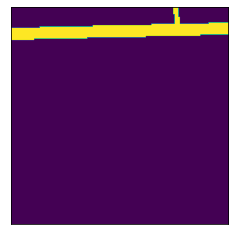

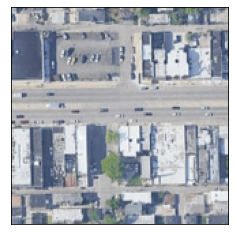

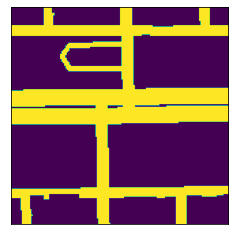

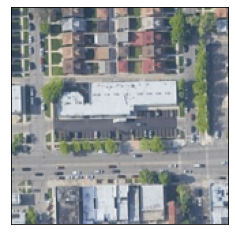

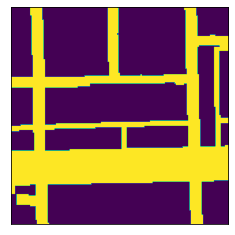

In [18]:
for u, v in zip(X, y):
    show_image(u)
    show_image(v)

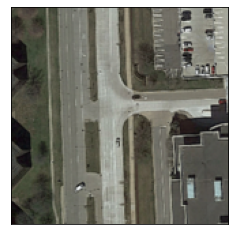

In [19]:
show_image(imgs[0][0])

# 2. Define Model / System

In [40]:
load_from_checkpoint = True

In [41]:
model = NestedUNet(1, 3)
model_name = str(model).partition('(')[0]

In [42]:
system = SemanticSegmentationSystem(model, road_data, n_closing=0)

In [43]:
if load_from_checkpoint:
    system = SemanticSegmentationSystem.load_from_checkpoint(f'{"./lightning_logs/" + model_name + "_data"}/{model_name + "_data"}.ckpt', model=model, datamodule=road_data)

# 4. Training

In [44]:
if torch.cuda.is_available():
    gpu_count = -1
    gpu_auto_select = True
else:
    gpu_count = 0
    gpu_auto_select = False

In [45]:
checkpoint_callback = ModelCheckpoint(
    monitor='validation_f1',
    dirpath='./lightning_logs',
    filename=model_name + '_fix',
    save_top_k=1,
    verbose=2,
    mode='max'
)

In [46]:
early_stop_callback = EarlyStopping(
   monitor='validation_f1',
   patience=50,
   verbose=1,
   mode='max'
)

In [47]:
if load_from_checkpoint:
    trainer = pl.Trainer(
        #fast_dev_run=True,
        gpus=gpu_count,
        auto_select_gpus=gpu_auto_select,
        stochastic_weight_avg=True,
        benchmark=True,
        callbacks=[early_stop_callback, checkpoint_callback],

        resume_from_checkpoint=f'{"./lightning_logs/" + model_name + "_data"}/{model_name + "_data"}.ckpt'
    )
    
else:
        trainer = pl.Trainer(
        #fast_dev_run=True,
        gpus=gpu_count,
        auto_select_gpus=gpu_auto_select,
        stochastic_weight_avg=True,
        benchmark=True,
        callbacks=[early_stop_callback, checkpoint_callback]
    )

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [48]:
%%time
if not load_from_checkpoint:
    trainer.fit(system)

CPU times: user 6 µs, sys: 1e+03 ns, total: 7 µs
Wall time: 12.6 µs


In [49]:
if gpu_count != 0:
    try:
        model.cuda()
    except:
        print("model not defined")
    try:
        model_fix.cuda()
    except:
        print("model fix not defined")
    try:
        model_fix_mask.cuda()
    except:
        print("model fix mask not defined")
else:
    try:
        model.cpu()
    except:
        print("model not defined")
    try:
        model_fix.cpu()
    except:
        print("model fix not defined")
    try:
        model_fix_mask.cpu()
    except:
        print("model fix mask not defined")


model fix not defined
model fix mask not defined


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


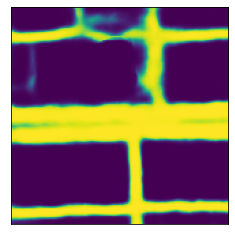

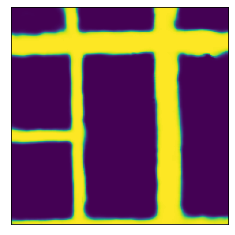

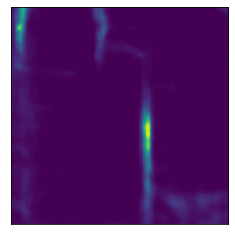

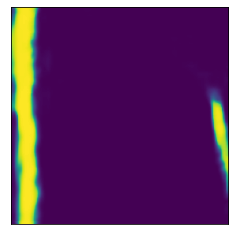

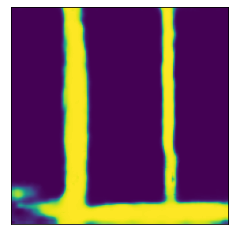

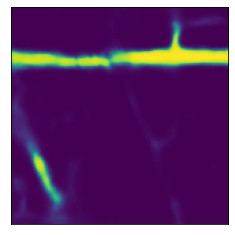

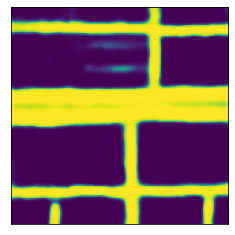

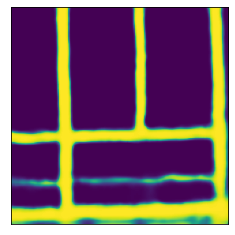

In [50]:
system.visualize_results()

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


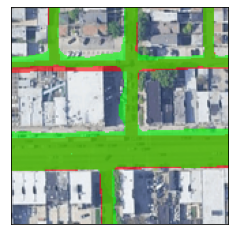

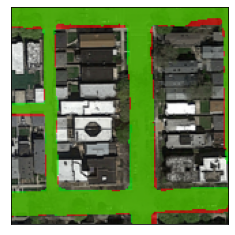

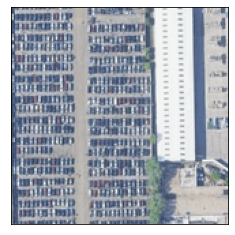

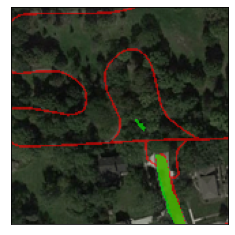

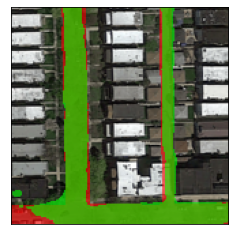

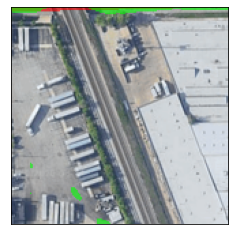

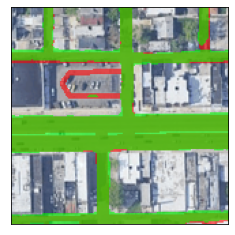

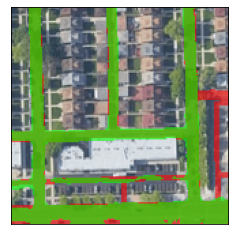

In [51]:
system.visualize_results_overlay()

# 5. Predict

In [52]:
if load_from_checkpoint:
    system = SemanticSegmentationSystem.load_from_checkpoint(f'{"./lightning_logs/" + model_name + "_data"}/{model_name + "_data"}.ckpt', model=model, datamodule=road_data)

In [53]:
if load_from_checkpoint:
    trainer.test(system, ckpt_path=f'{"./lightning_logs/" + model_name + "_data"}/{model_name + "_data"}.ckpt')

else:
    trainer.test(system)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{}
--------------------------------------------------------------------------------


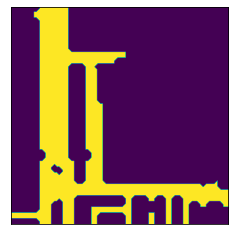

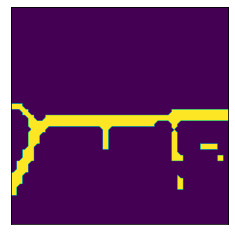

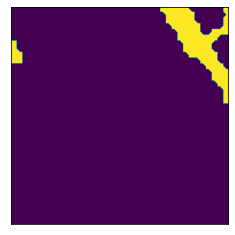

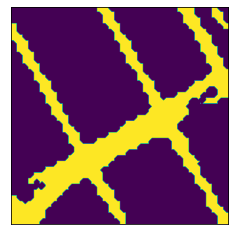

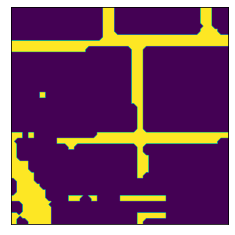

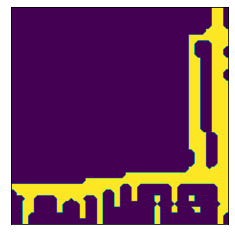

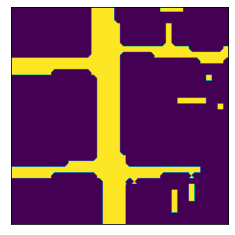

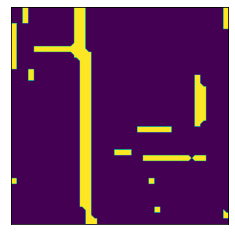

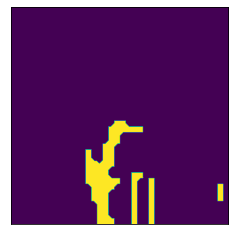

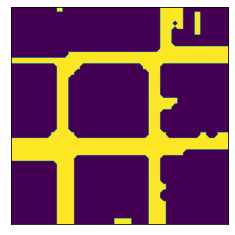

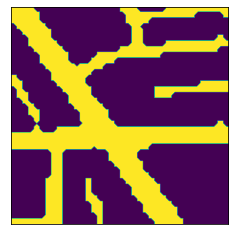

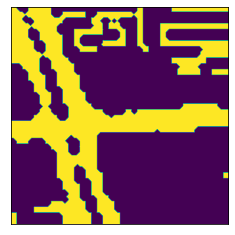

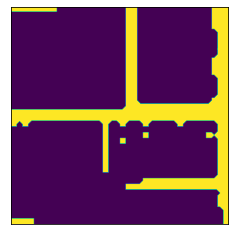

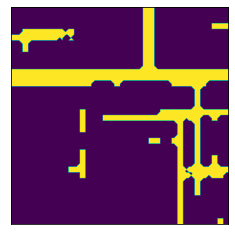

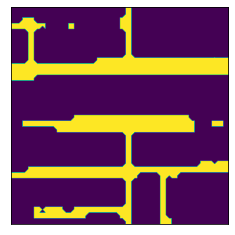

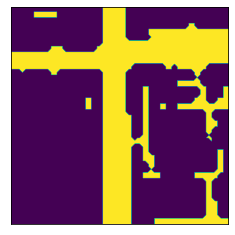

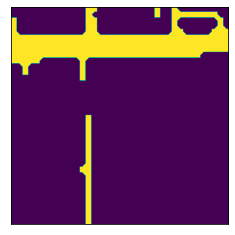

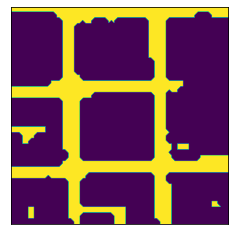

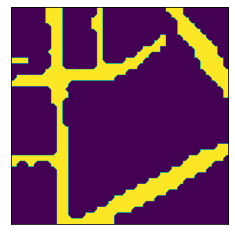

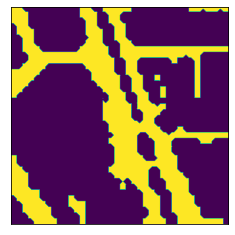

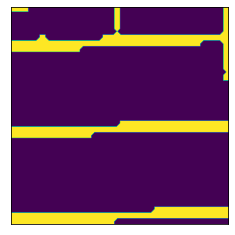

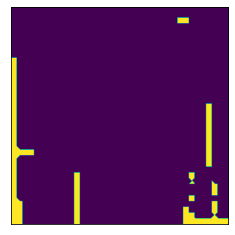

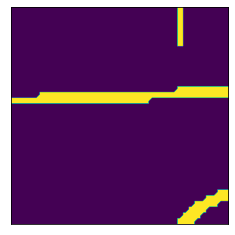

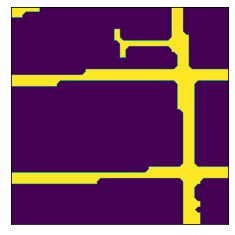

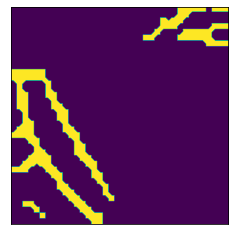

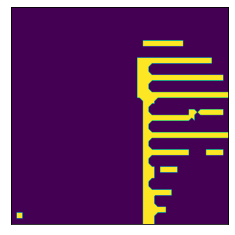

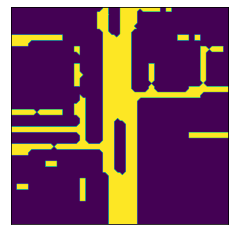

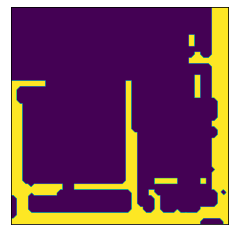

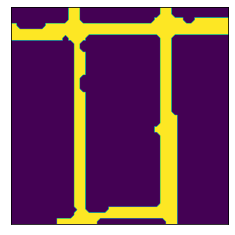

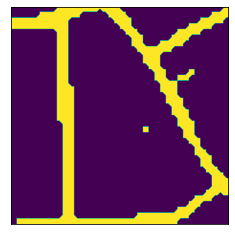

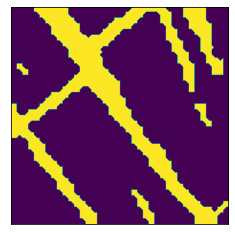

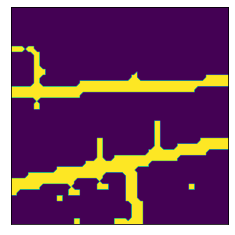

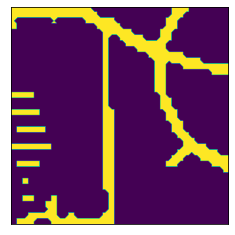

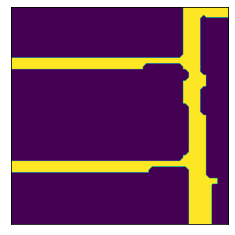

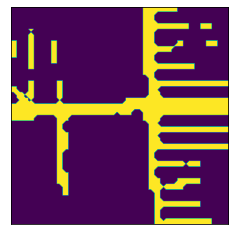

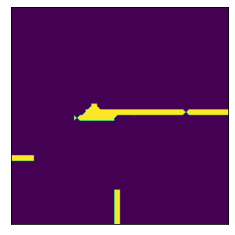

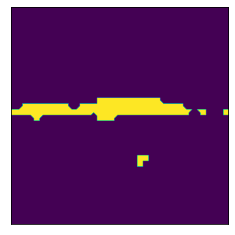

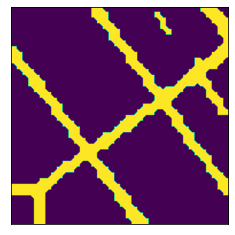

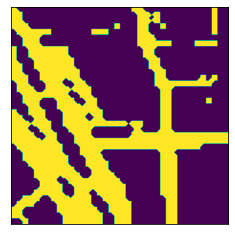

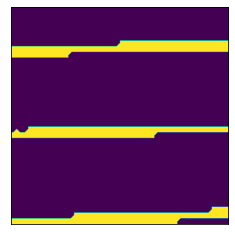

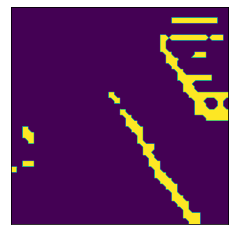

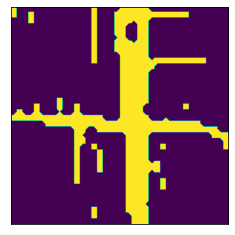

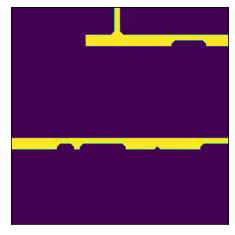

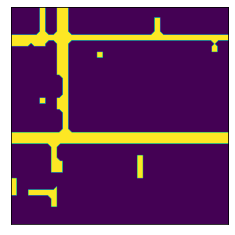

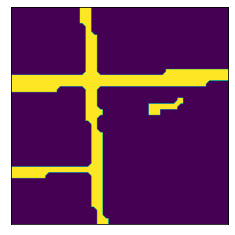

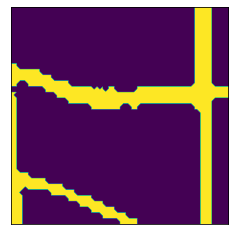

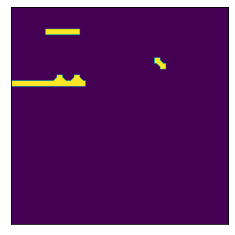

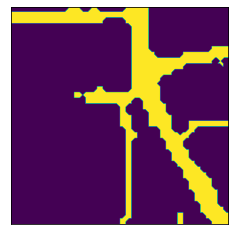

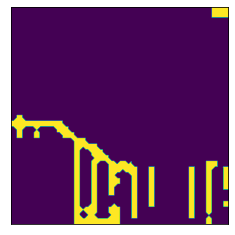

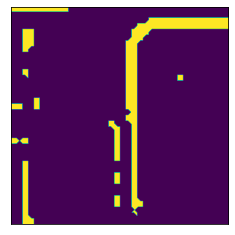

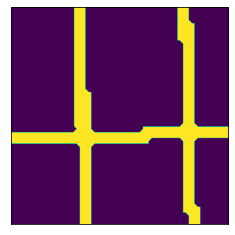

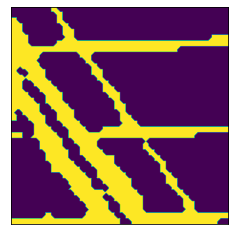

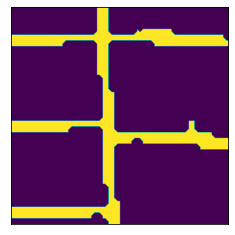

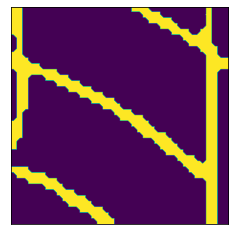

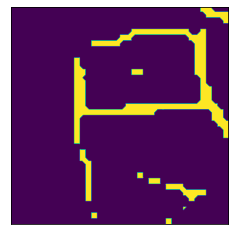

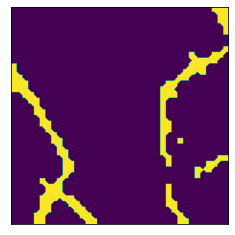

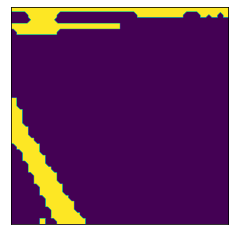

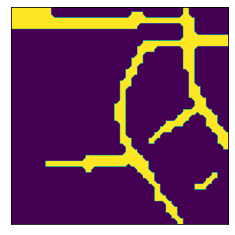

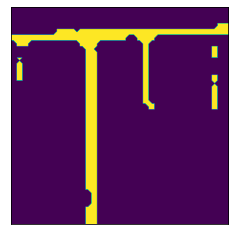

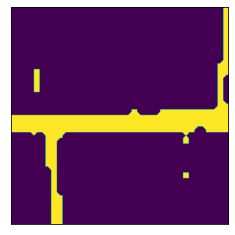

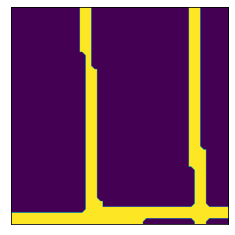

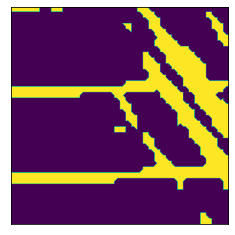

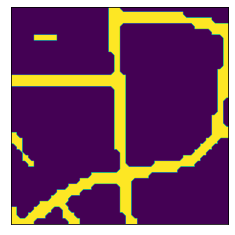

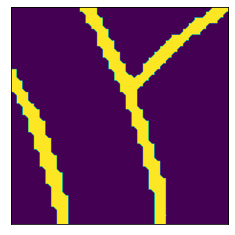

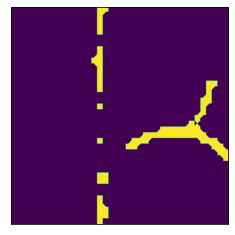

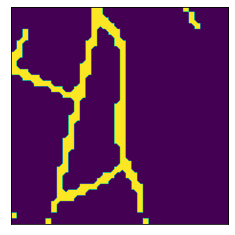

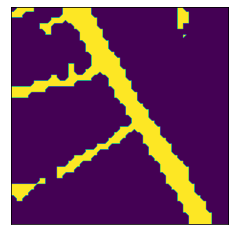

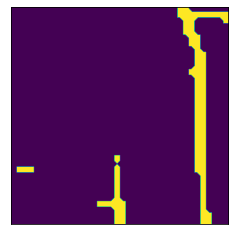

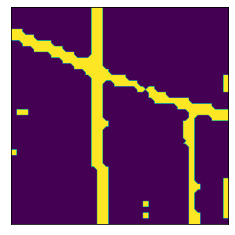

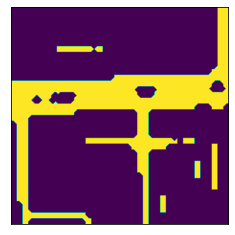

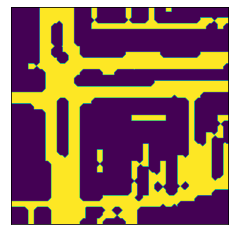

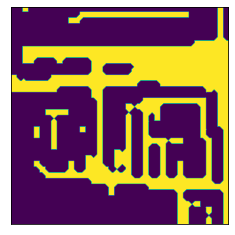

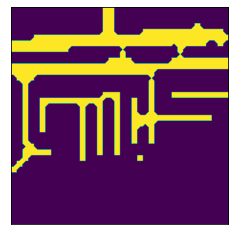

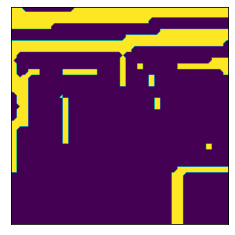

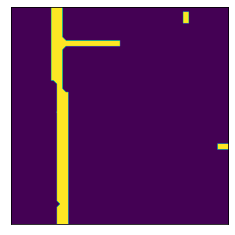

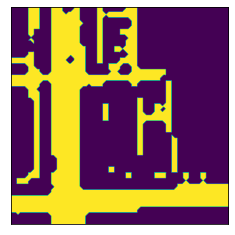

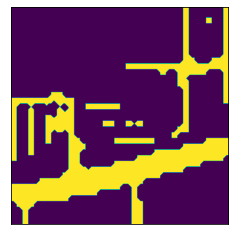

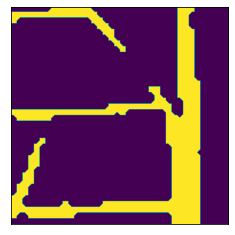

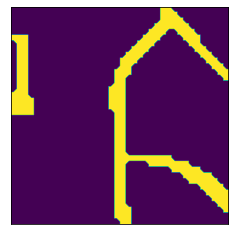

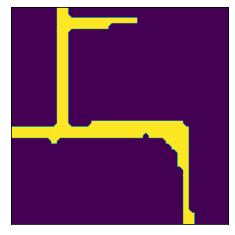

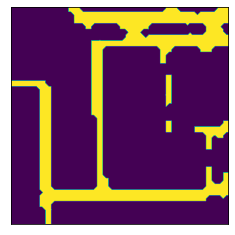

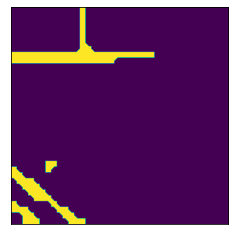

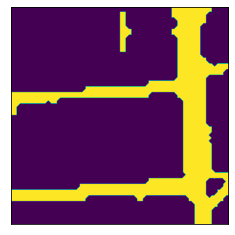

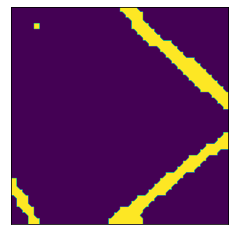

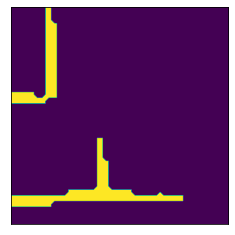

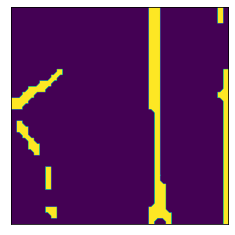

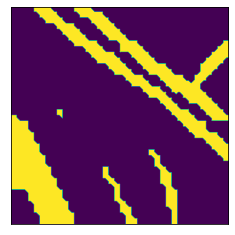

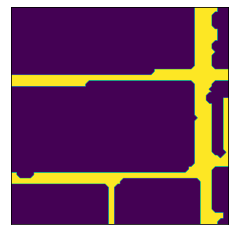

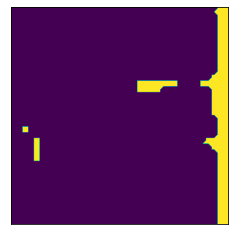

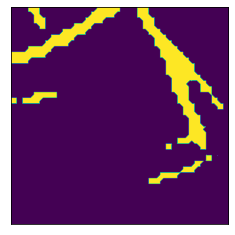

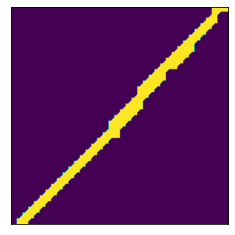

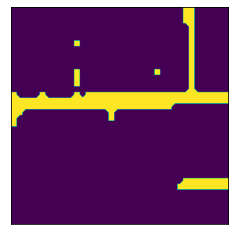

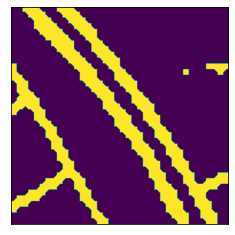

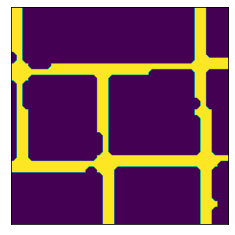

In [54]:
for t in system.test_results:
    show_image(t[0])

In [55]:
foreground_threshold = 0.25 # percentage of pixels > 1 required to assign a foreground label to a patch

# assign a label to a patch
def patch_to_label(patch):
    df = np.mean(patch)
    if df > foreground_threshold:
        return 1
    else:
        return 0
    
def mask_to_patched_mask(image):
    patched_image = image.squeeze().detach().clone()
    image = np.asarray(image.squeeze())
    patch_size = 16
    for j in range(0, image.shape[1], patch_size):
        for i in range(0, image.shape[0], patch_size):
            patch = image[i:i + patch_size, j:j + patch_size]
            label = patch_to_label(patch)
            patched_image[i:i + patch_size, j:j + patch_size] = label
    return patched_image

def mask_to_submission_strings(im, name):
    """Reads a single image and outputs the strings that should go into the submission file"""
    img_number = int(re.search(r"\d+", name).group(0))
    #im = mpimg.imread(image_filename) 
    # image is gray scale therefore size MxN with imread 
    patch_size = 16
    for j in range(0, im.shape[1], patch_size):
        for i in range(0, im.shape[0], patch_size):
            patch = im[i:i + patch_size, j:j + patch_size]
            label = patch_to_label(patch)
            yield("{:03d}_{}_{},{}".format(img_number, j, i, label))


def masks_to_submission(submission_filename, *images):
    """Converts images into a submission file"""
    with open(submission_filename, 'w') as f:
        f.write('id,prediction\n')
        for imgs, fn in images[0:]:
            f.writelines('{}\n'.format(s) for s in mask_to_submission_strings(imgs, fn))

In [56]:
batches = system.test_results

In [57]:
model_name = 'Cillers'

In [58]:
submission_filename = model_name + '_predictions.csv'
pred_counter = 0

In [59]:
with open(submission_filename, 'w') as f:
        f.write('id,prediction\n')
        
        for mask, name in batches:
            predicted_mask = np.asarray(mask.cpu().squeeze())

            ids = mask_to_submission_strings(predicted_mask, name)
            f.writelines('{}\n'.format('\n'.join(ids)))

            pred_counter += 1
pred_counter

94